In [2]:
# Imports 
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from pycocotools.coco import COCO
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch.optim as optim

In [3]:
# Define the COCO dataset class
class COCODataset(Dataset):
    def __init__(self, annotation_file, image_dir, transforms=None):
        self.coco = COCO(annotation_file)
        self.image_dir = image_dir
        self.transforms = transforms
        self.ids = list(self.coco.imgs.keys())

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)
        image_info = coco.loadImgs(img_id)[0]
        path = image_info['file_name']

        img = cv2.imread(os.path.join(self.image_dir, path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        num_objs = len(anns)
        boxes = []
        labels = []
        for i in range(num_objs):
            xmin = anns[i]['bbox'][0]
            ymin = anns[i]['bbox'][1]
            xmax = xmin + anns[i]['bbox'][2]
            ymax = ymin + anns[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(anns[i]['category_id'])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        if boxes.ndim == 1:
            boxes = boxes.unsqueeze(0)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([img_id])
        
        if boxes.size(0) > 0:  # Check if there are any boxes
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        else:
            area = torch.tensor([])

        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.ids)

In [4]:
# Define transforms
transform = transforms.Compose([transforms.ToTensor()])

# Initialize dataset and dataloader
annotation_file = 'university_annotations/train/_annotations.coco.json'
image_dir = 'university_annotations/train/train_images'
dataset = COCODataset(annotation_file, image_dir, transforms=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))


loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


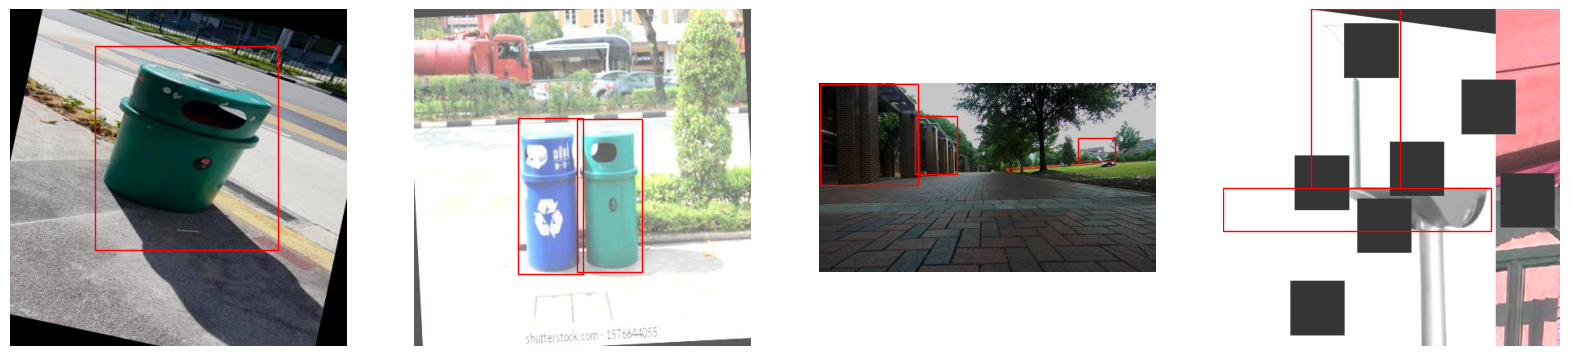

In [5]:
# Function to visualize a batch of images
def visualize_batch(images, targets):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 5))
    for i, (img, target) in enumerate(zip(images, targets)):
        img = img.permute(1, 2, 0).numpy()  # Convert tensor to numpy array
        img = (img * 255).astype(np.uint8)  # Convert to uint8
        axes[i].imshow(img)
        boxes = target['boxes'].numpy()
        for box in boxes:
            xmin, ymin, xmax, ymax = box
            rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color='red')
            axes[i].add_patch(rect)
        axes[i].axis('off')
    plt.show()

# Get a batch of data
images, targets = next(iter(dataloader))

# Visualize the batch
visualize_batch(images, targets)

In [7]:
# Load a pre-trained model for classification and return only the features
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1)

# Get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the pre-trained head with a new one
num_classes = len(dataset.coco.getCatIds()) + 1  # COCO class IDs + background class
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Move the model to the right device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [9]:
num_epochs = 2
learning_rate = 0.005
model_save_path = "model.pt"
# Define the optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=learning_rate, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop
for epoch in range(num_epochs):
    model.train()
    print(f"Starting epoch {epoch + 1}/{num_epochs}")
    i = 0
    for images, targets in dataloader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        losses.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f"Epoch: {epoch + 1}/{num_epochs}, Iteration: {i}, Loss: {losses.item():.4f}")
        i += 1

    # Update the learning rate
    lr_scheduler.step()
    print(f"Finished epoch {epoch + 1}/{num_epochs}, Loss: {losses.item():.4f}")
    # Save the model at the end of each epoch
    torch.save(model.state_dict(), f"model_epoch_{epoch + 1}.pth")
    print(f"Finished epoch {epoch + 1}/{num_epochs}, Loss: {losses.item():.4f}")

# Save the final model
torch.save(model.state_dict(), model_save_path)
print("Training complete. Model saved.")
print("Training complete.")


Starting epoch 1/2
Epoch: 1/2, Iteration: 0, Loss: 0.3277
Epoch: 1/2, Iteration: 10, Loss: 0.4444
Epoch: 1/2, Iteration: 20, Loss: 0.4663
Epoch: 1/2, Iteration: 30, Loss: 0.2959
Epoch: 1/2, Iteration: 40, Loss: 0.1799
Epoch: 1/2, Iteration: 50, Loss: 0.1589
Epoch: 1/2, Iteration: 60, Loss: 0.2483
Epoch: 1/2, Iteration: 70, Loss: 0.3111
Epoch: 1/2, Iteration: 80, Loss: 0.1931
Epoch: 1/2, Iteration: 90, Loss: 0.4499
Epoch: 1/2, Iteration: 100, Loss: 0.0596
Epoch: 1/2, Iteration: 110, Loss: 0.2224
Epoch: 1/2, Iteration: 120, Loss: 0.3702
Epoch: 1/2, Iteration: 130, Loss: 0.2621
Epoch: 1/2, Iteration: 140, Loss: 0.2746
Epoch: 1/2, Iteration: 150, Loss: 0.3097
Epoch: 1/2, Iteration: 160, Loss: 0.1510
Epoch: 1/2, Iteration: 170, Loss: 0.2689
Epoch: 1/2, Iteration: 180, Loss: 0.4483
Epoch: 1/2, Iteration: 190, Loss: 0.2187
Epoch: 1/2, Iteration: 200, Loss: 0.3422
Epoch: 1/2, Iteration: 210, Loss: 0.1552
Epoch: 1/2, Iteration: 220, Loss: 0.2179
Epoch: 1/2, Iteration: 230, Loss: 0.5185
Epoch: 1

In [60]:
# Load the model 
model_save_path = "model_epoch_1.pth"
model.load_state_dict(torch.load(model_save_path))
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

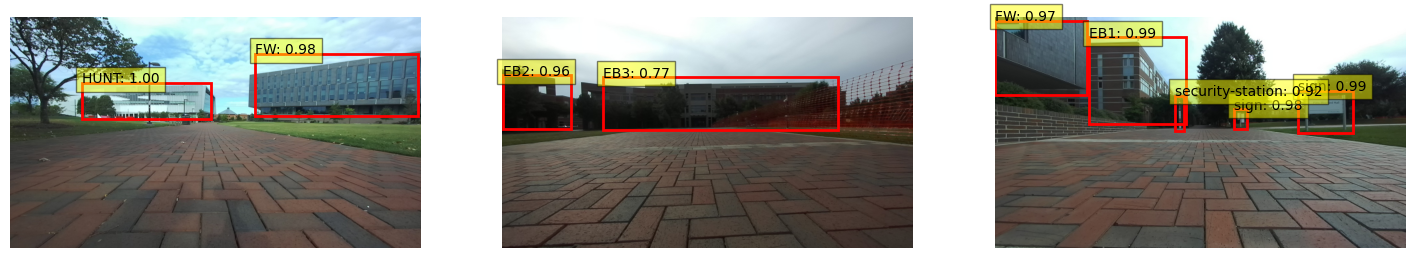

In [61]:
from PIL import Image
import matplotlib.patches as patches

transform = transforms.Compose([
    transforms.ToTensor(),  
])

def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image)
    return image.unsqueeze(0) 

# Load and preprocess the test images
test_image_path1 = 'test_image1.jpg'
test_image_path2 = 'test_image2.jpg'
test_image_path3 = 'test_image3.jpg'
test_image1 = load_image(test_image_path1).to(device)
test_image2 = load_image(test_image_path2).to(device)
test_image3 = load_image(test_image_path3).to(device)

# Disable gradient calculation for inference
with torch.no_grad():
    prediction1 = model(test_image1)
    prediction2 = model(test_image2)
    prediction3 = model(test_image3)

# Define categories as per the COCO dataset
categories = [
    {"id": 0, "name": "sign"},
    {"id": 1, "name": "EB1"},
    {"id": 2, "name": "EB2"},
    {"id": 3, "name": "EB3"},
    {"id": 4, "name": "FW"},
    {"id": 5, "name": "HUNT"},
    {"id": 6, "name": "OVAL"},
    # {"id": 7, "name": "building"},
    {"id": 8, "name": "security-station"},
    {"id": 9, "name": "sign"},
    {"id": 10, "name": "street-lamp"},
    # {"id": 11, "name": "structure"},
    {"id": 12, "name": "trashcan"},
]

# Create a dictionary to map label IDs to category names
label_to_category = {cat['id']: cat['name'] for cat in categories}

def visualize_predictions(images, predictions, threshold=0.5):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    for ax, image, prediction in zip(axs, images, predictions):
        # Convert the tensor image to a NumPy array and transpose the dimensions
        image_np = image.squeeze().permute(1, 2, 0).cpu().numpy()
        ax.imshow(image_np)

        boxes = prediction[0]['boxes'].cpu().numpy()
        scores = prediction[0]['scores'].cpu().numpy()
        labels = prediction[0]['labels'].cpu().numpy()

        for box, score, label in zip(boxes, scores, labels):
            if score >= threshold:
                xmin, ymin, xmax, ymax = box
                rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                ax.text(xmin, ymin, f'{label_to_category.get(label, "Unknown")}: {score:.2f}', 
                        bbox=dict(facecolor='yellow', alpha=0.5))

        ax.axis('off')

    plt.show()

# Visualize predictions for all three images
visualize_predictions([test_image1, test_image2, test_image3], [prediction1, prediction2, prediction3])


In [71]:
# Load and preprocess the images
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image)
    return image.unsqueeze(0)

# Function to annotate images in COCO format
def annotate_images_in_folder(folder_path, output_json_path, threshold=0.5):
    image_id = 1
    annotation_id = 1
    coco_annotations = {
        "images": [],
        "annotations": [],
        "categories": categories
    }

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if not os.path.isfile(file_path):
            continue  # Skip directories and non-files
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            image = load_image(file_path).to(device)

            with torch.no_grad():
                prediction = model(image)

            image_np = image.squeeze().permute(1, 2, 0).cpu().numpy()
            height, width, _ = image_np.shape

            coco_annotations["images"].append({
                "id": image_id,
                "file_name": filename,
                "width": int(width),
                "height": int(height)
            })

            boxes = prediction[0]['boxes'].cpu().numpy()
            scores = prediction[0]['scores'].cpu().numpy()
            labels = prediction[0]['labels'].cpu().numpy()

            for box, score, label in zip(boxes, scores, labels):
                if score >= threshold:
                    xmin, ymin, xmax, ymax = box
                    width = xmax - xmin
                    height = ymax - ymin
                    coco_annotations["annotations"].append({
                        "id": annotation_id,
                        "image_id": image_id,
                        "category_id": int(label),
                        "bbox": [float(xmin), float(ymin), float(width), float(height)],
                        "score": float(score)
                    })
                    annotation_id += 1

            image_id += 1

    # Print the annotations to ensure they are correct
    # print(json.dumps(coco_annotations, indent=4))
    
    # Save the annotations to a JSON file
    with open(output_json_path, 'w') as f:
        json.dump(coco_annotations, f, indent=4)

In [72]:
# Specify the folder containing test images and the output JSON path
test_images_folder = 'images/test_img'
output_json_path = 'annotations.json'

# Annotate images and save annotations in COCO format
annotate_images_in_folder(test_images_folder, output_json_path)

In [73]:
# Optional: Visualize some predictions
test_image_paths = [os.path.join(test_images_folder, f) for f in os.listdir(test_images_folder)]
test_images = [load_image(p).to(device) for p in test_image_paths]
with torch.no_grad():
    predictions = [model(img) for img in test_images]

visualize_predictions(test_images, predictions)

IsADirectoryError: [Errno 21] Is a directory: '/home/jyu34/Desktop/project-oval/ML/DeepLearning/DataSetup/images/test_img/.ipynb_checkpoints'